<a href="https://colab.research.google.com/github/andygma567/X-Ray-Image-Classification/blob/main/Transfer_Learning_with_Keras_for_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

I made this transfer learning example with Inception.V3 for comparison to my own CNN. This particular example is trained on the same dataset as my CNN example and it has 89% accuracy on the same test data as my CNN. Overall I think this is a better model. 

# Introduction

I followed these tutorials from the tensorflow site:
1.   https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning
2.   https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning
3.   https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

For a quick overview of Inception.V3 in comparison to ResNet and other CNN type neural nets I like this blogpost: 

https://blog.paperspace.com/popular-deep-learning-architectures-resnet-inceptionv3-squeezenet/

# Set up

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np # I'm not sure if I need this one
import os 

#for reproducibility of result I use the same seed for the random number generator
tf.random.set_seed(42) 

print(tf.__version__)

2.8.2


In [ ]:
# Get the gpu info 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug 15 05:48:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |   8267MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# # Mount my Google Drive
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

## Load my dataset



In [ ]:
# Get my dataset from where I store it in my Google Drive
data_dir = '/content/drive/MyDrive/X-Ray classification/classification-challenge-starter/Covid19-dataset/'

# I use the same seed for reproducability
SEED = 123 

# This is my training set
train_ds = keras.utils.image_dataset_from_directory(
    data_dir + 'train', 
    validation_split=0.2,
    subset="training",
    seed = SEED
    )

# This is my validation set
val_ds = keras.utils.image_dataset_from_directory(
    data_dir + 'train', 
    validation_split=0.2,
    subset="validation",
    seed = SEED
    )

# This is my test set
test_ds = keras.utils.image_dataset_from_directory(
    data_dir + 'test', 
    seed = SEED
    )

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.
Found 66 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Pneumonia']


Here I try to optimize my data pipeline setup. It's definitely not necessary for my small dataset but I think it's a good habit for me to always do this step. 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build a Model

## Get the inception.v3 neural net for a base

I'm using the model that is from the Keras library. I also experimented using the same model that is in the Tensorflow Hub page but that model doesn't allow you to fine-tune just a fraction of the model. 

At the time of this writing (August 2022) the Tensorflow Hub models are interpretted as a single layer during fine-tuning in tensorflow. 

In [ ]:
# Create the base model from the pre-trained model

IMG_SIZE = (256, 256) # All of my images have the shape (256, 256, 3) 
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3 (
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet', 
    pooling = 'avg' 
)

In [ ]:
# Freeze all the weights in the base model
base_model.trainable = False

## Make image preprocessing layers

In [ ]:
# make a preprocessing layer
data_augmentation = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    # Zoom in or out by 5%
    layers.RandomZoom(height_factor = .15, width_factor= .15),
    # Rotate by about 15 degrees - that's a little over 4%
    layers.RandomRotation(factor = .04),
    #Translate by up to 3% up, down, left, or right
    layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1)
])

## Build a Model

Special attention needs to be given to the batchnormalization layers as tensorflow handles them in a special way. 

In [ ]:
def create_model():
  # Create new model on top
  inputs = keras.Input(shape=(256, 256, 3))
  x = data_augmentation(inputs)  # Apply random data augmentation

  # The base model contains batchnorm layers. We want to keep them in inference mode
  # when we unfreeze the base model for fine-tuning, so we make sure that the
  # base_model is running in inference mode here.
  x = base_model(x, training=False)
  x = layers.Dropout(0.2)(x)  # Regularize with dropout
  outputs = keras.layers.Dense(3, activation="softmax")(x) # we have 3 classes

  model = keras.Model(inputs, outputs)

  base_learning_rate = 1e-4
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss= keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])

  return model

In [ ]:
model = create_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


# Train the Model

To help save training progress I use a checkpoint callback that I store in a directory called "training" (on the virtual machine connected my colab notebook)

In [ ]:
# save one checkpoint at a time into my drive
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# Create a callback that saves the model's weights
cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=True,
                                        save_best_only=True,
                                        verbose=1)

In [ ]:
initial_epochs = 15

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks = [cp]
                    )

Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 1.0674 - acc: 0.4378
Epoch 1: val_loss improved from inf to 1.08061, saving model to training/cp.ckpt
7/7 [==============================] - 11s 450ms/step - loss: 1.0674 - acc: 0.4378 - val_loss: 1.0806 - val_acc: 0.4000
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 0.9893 - acc: 0.5025
Epoch 2: val_loss improved from 1.08061 to 1.00981, saving model to training/cp.ckpt
7/7 [==============================] - 1s 206ms/step - loss: 0.9893 - acc: 0.5025 - val_loss: 1.0098 - val_acc: 0.4800
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 0.9909 - acc: 0.4826
Epoch 3: val_loss improved from 1.00981 to 0.97218, saving model to training/cp.ckpt
7/7 [==============================] - 1s 174ms/step - loss: 0.9909 - acc: 0.4826 - val_loss: 0.9722 - val_acc: 0.5400
Epoch 4/15
6/7 [========================>.....] - ETA: 0s - loss: 0.9729 - acc: 0.5417
Epoch 4: val_loss improved from 0.97218 to 

## Plot the Accuracy and the Loss

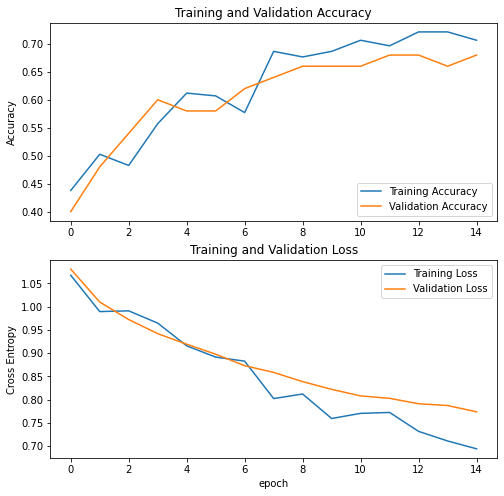

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [ ]:
# Fine tune the top 20% of layers
fine_tune_at = int(len(base_model.layers)*.2)

base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# I want to use a much smaller learning rate for fine-tuning because it's
# very easy to overfit such a large model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss= keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 21,069,811
Non-trainable params: 739,120
_________________________________________________________________
None


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds, 
                         callbacks = [cp]
                         )

Epoch 15/25
7/7 [==============================] - ETA: 0s - loss: 0.7004 - acc: 0.7114
Epoch 15: val_loss improved from 0.77381 to 0.62157, saving model to training/cp.ckpt
7/7 [==============================] - 12s 621ms/step - loss: 0.7004 - acc: 0.7114 - val_loss: 0.6216 - val_acc: 0.7400
Epoch 16/25
7/7 [==============================] - ETA: 0s - loss: 0.5069 - acc: 0.8060
Epoch 16: val_loss improved from 0.62157 to 0.55568, saving model to training/cp.ckpt
7/7 [==============================] - 2s 364ms/step - loss: 0.5069 - acc: 0.8060 - val_loss: 0.5557 - val_acc: 0.8000
Epoch 17/25
7/7 [==============================] - ETA: 0s - loss: 0.4441 - acc: 0.8308
Epoch 17: val_loss improved from 0.55568 to 0.46598, saving model to training/cp.ckpt
7/7 [==============================] - 2s 343ms/step - loss: 0.4441 - acc: 0.8308 - val_loss: 0.4660 - val_acc: 0.8000
Epoch 18/25
7/7 [==============================] - ETA: 0s - loss: 0.3040 - acc: 0.9005
Epoch 18: val_loss improved from

## Plot the Accuracy and Loss after Fine Tuning

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

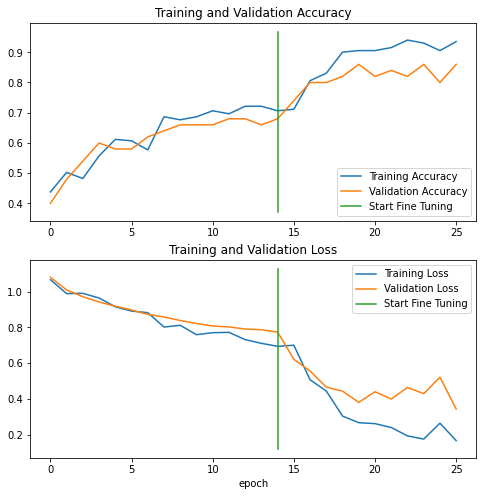

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate the Model

Here we use the checkpoint callback to load the best model we have seen (according to the loss)

In [ ]:
best_model = create_model()
best_model.load_weights(checkpoint_path)

In [ ]:
best_model.evaluate(test_ds)

3/3 [==============================] - 2s 45ms/step - loss: 0.2702 - acc: 0.8939


[0.2702481746673584, 0.8939393758773804]

## Save the Trained Transfer Learning Model

In [ ]:
old_model = tf.keras.models.load_model('/drive/MyDrive/X-Ray classification/Transfer Learning/saved_model/my_model')

old_loss, old_acc = old_model.evaluate(test_ds)
print("Old saved model")

3/3 [==============================] - 0s 8ms/step - loss: 0.2496 - categorical_accuracy: 0.8636 - auc: 0.9765
Old saved model


In [ ]:
if old_acc < acc: 
  print('Saved best_model over the prev model')
  best_model.save('drive/MyDrive/X-Ray classification/Transfer Learning/saved_model/my_model')
else:
  best_model = old_model

## Classification Report and Confusion Matrix

A (i, j) entry in a confusion matrix means that the true label was class_i but the model predicted class_j. This confusion matrix is also normalized so that it sums to 1. 

In [ ]:
y_pred = tf.argmax(best_model.predict(test_ds), axis = 1).numpy()
ds = test_ds.take(-1).unbatch()
# numpy() is used to convert a tf tensor to a numpy array
y_true = [y.numpy() for x, y in ds] 

              precision    recall  f1-score   support

       Covid       1.00      0.96      0.98        26
      Normal       0.93      0.70      0.80        20
   Pneumonia       0.77      1.00      0.87        20

    accuracy                           0.89        66
   macro avg       0.90      0.89      0.88        66
weighted avg       0.91      0.89      0.89        66



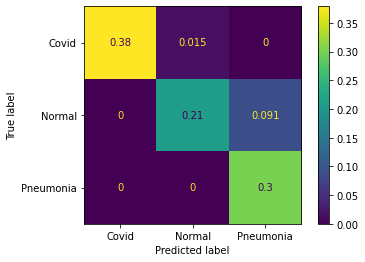

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names = class_names))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= class_names)
disp.plot()